## Foraminifera Data

In [1]:
from grainsize import Forams

Import raw foraminifera counting data for size fraction of 125 microns

In [2]:
sr19 = Forams(fname="./data-files/mp-files/sr19-forams.csv", size_fraction=125)
sr21 = Forams(fname="./data-files/mp-files/sr21-forams.csv", size_fraction=125)

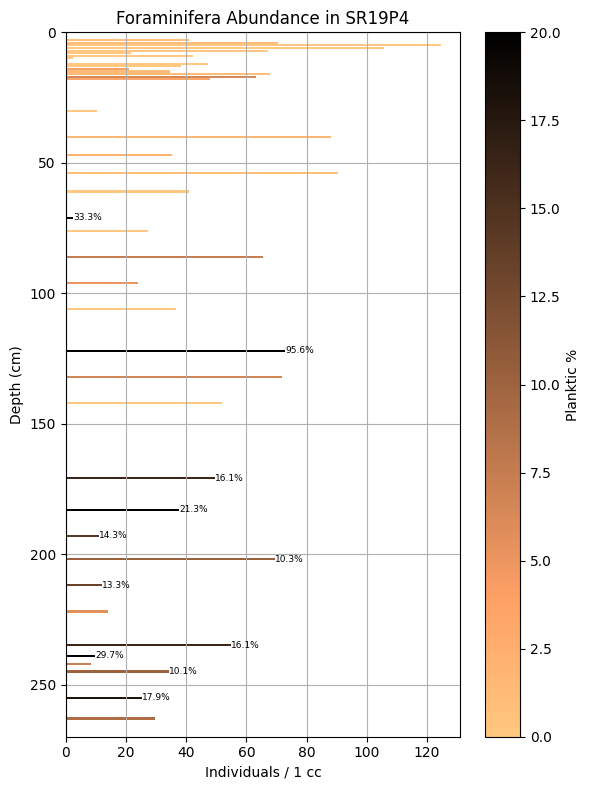

In [3]:
sr19_forams_plot = sr19.plot_forams(
    core_name="SR19P4",
    limit_sm=True,
    sm_limit=20,
    cmap="copper_r",
    savefig=False,
    savepath="./data-files/mp-files/sr19-forams.png",
)

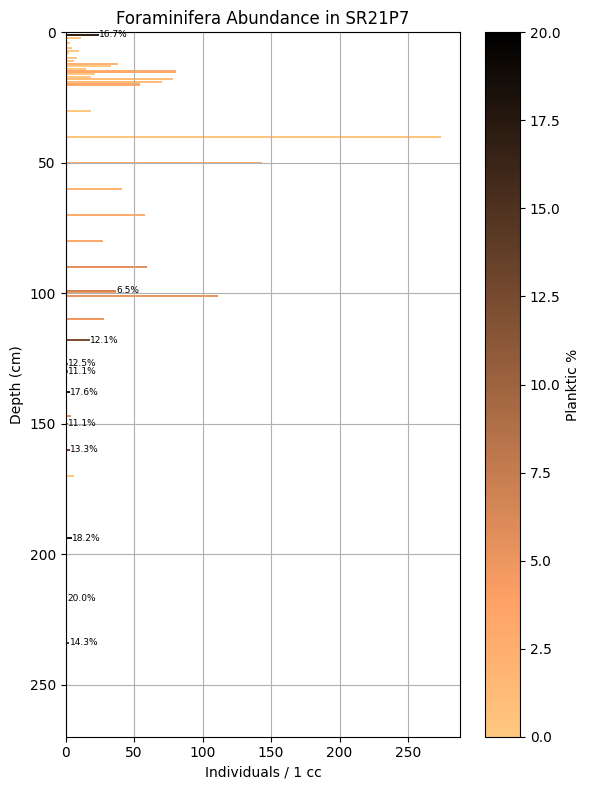

In [4]:
sr21_forams_plot = sr21.plot_forams(
    core_name="SR21P7",
    limit_sm=True,
    sm_limit=20,
    cmap="copper_r",
    savefig=False,
    savepath="./data-files/mp-files/sr21-forams.png"
)

### A combined plot of forams for comparison

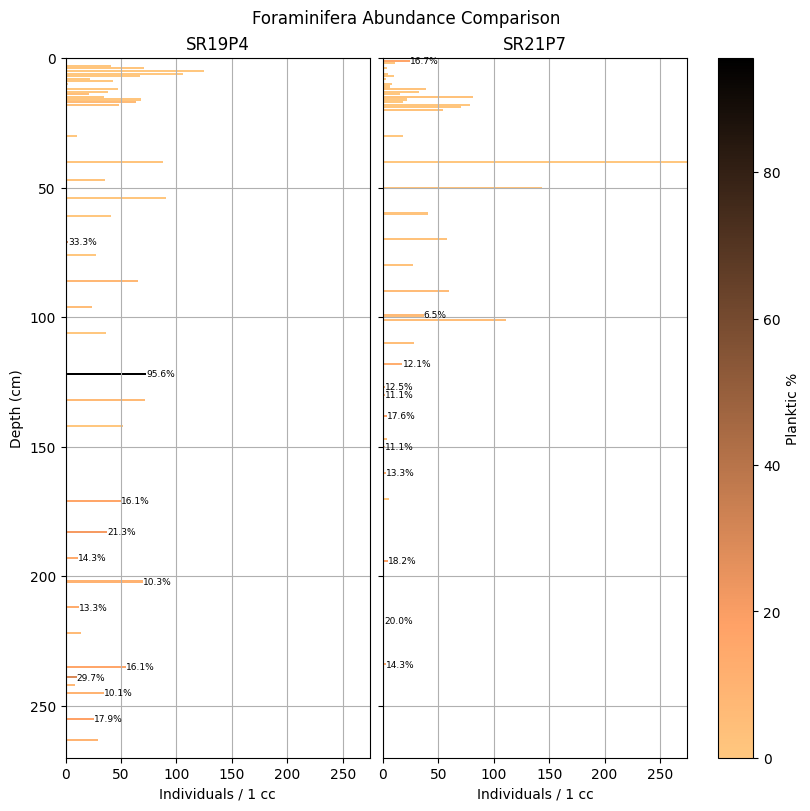

In [5]:
compared_forams = sr19.compare_forams_plot(
    cores=[sr19, sr21],
    core_names=["SR19P4", "SR21P7"],
    cmap="copper_r",
    savefig=False,
    savepath="./data-files/mp-files/sr19-sr21-forams.png"
)

## Statistical Comparison of Foraminifera Data

### Bayesian Hirearchical Model

#### Goal:

Compare the foraminifera data for the two cores in terms of:
1. Total normalized abundance per 1 cc (`normalized_per_1cc` column)
2. Planktic percent out of the normalized total abundance (`planktic_percent` column)

Since depth is a confounding factor, we will use a hierarchical model to account for the depth effect.

Step 1: Organizing the data

In [6]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

In [7]:
hm_sr19 = sr19.dataframe.loc[:, ["normalized_per_1cc", "planktic_percent"]].reset_index()
hm_sr21 = sr21.dataframe.loc[:, ["normalized_per_1cc", "planktic_percent"]].reset_index()

In [8]:
# concat the dataframes and label each sample according to the corresponding core
hm_data = pd.concat([hm_sr19, hm_sr21], ignore_index=True)
hm_data["core"] = ["SR19P4"] * len(hm_sr19) + ["SR21P7"] * len(hm_sr21)

In [9]:
# normalize the planktic percentage to values between 0 and 1
hm_data["planktic_percent"] = hm_data["planktic_percent"] / 100

#### Prior Assumptions

**Total Abundance**:

The prior assumption is that the abundance of forams corresponds to a normal distribution: $y_i \sim \text{Normal}(\mu_i, \sigma)$, where: 
$y_i$ is the abundance (per 1 cc) in sample *i*, and $\mu_i = \alpha_i + \beta_i * depth_i$ such that each core has its own intercept $\alpha_i$ and slope $\beta_i$, and the parameters originate from group-level distributions (*group* is the core in this case).

**Planktic Fraction**:

The data appear to present a skewed trend, where below certain depth (~122 cm in SR19P4 and ~100 cm in SR21P7) the planktic fraction is higher, but still linearly inconsistent. Therefore, we will apply a Beta regression model to the planktic fraction data, where the response variable is the proportion of planktic forams out of the total abundance.

In [10]:
# drop null values from the data
hm_data.dropna(inplace=True)
# convert core id to categorical data
hm_data["core_id"] = hm_data["core"].astype("category").cat.codes